In [1]:
import numpy as np
import tensorflow as tf
import mdn

In [2]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Dense, Attention
from tensorflow.keras.layers import (Conv2D, Input, Reshape, 
                                     Lambda, Dense, Conv2DTranspose)

In [3]:
import matplotlib.pyplot as plt
import os
import utils
from utils import sampling

## MDN-RNN

In [4]:
seq_len = 128
act_len = 3

In [67]:
OUTPUT_DIMS = 1
N_MIXES     = 5

In [70]:
M = Sequential([
    Input((seq_len, act_len + utils.LATENT_SIZE)),
    LSTM(256),
    mdn.MDN(OUTPUT_DIMS, N_MIXES)
])

M.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS, N_MIXES), 
          optimizer=tf.keras.optimizers.Adam()
         )
M.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                8704      
_________________________________________________________________
mdn_7 (MDN)                  (None, 15)                495       
Total params: 9,199
Trainable params: 9,199
Non-trainable params: 0
_________________________________________________________________


## Sausage2Seq

In [52]:
trace_dir = './data/traces'

In [8]:
traces = os.listdir(trace_dir)

In [9]:
trace = np.load(os.path.join(trace_dir, traces[0]))

In [ ]:
# BATCH_SIZE = 128
# LATENT_SIZE = 32

In [10]:
ims = trace['b']

In [11]:
ims = utils.preprocess_images(ims)

In [12]:
im = ims[0]

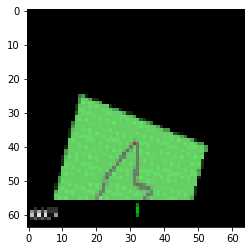

In [13]:
plt.imshow(im)

In [14]:
def Encoder(LATENT_SIZE=32):
    inputs = Input(shape=(64, 64, 3), name='encoder_input')
    h = Conv2D(32, 4, strides=2, activation="relu", name="enc_conv1")(inputs)
    h = Conv2D(64, 4, strides=2, activation="relu", name="enc_conv2")(h)
    h = Conv2D(128, 4, strides=2, activation="relu", name="enc_conv3")(h)
    h = Conv2D(256, 4, strides=2, activation="relu", name="enc_conv4")(h)
    h = Reshape([2*2*256])(h)
    z_mean = Dense(LATENT_SIZE, name='z_mean')(h)
    z_log_var = Dense(LATENT_SIZE, name='z_log_var')(h)
    z = Lambda(sampling, output_shape=(LATENT_SIZE,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

In [15]:
e = Encoder()

In [16]:
e.load_weights('./data/weights/encoder_weights.h5')

In [53]:
z = utils.to_latent(e, ims)

In [54]:
def sausage_to_seq(sausage, seq_len):
    return np.array(np.split(sausage, sausage.shape[0] / seq_len))

In [55]:
y_true = sausage_to_seq(z, seq_len)

In [56]:
y_true_ = np.array(np.split(y_true, z.shape[0] / utils.BATCH_SIZE))

In [36]:
y_true_.shape

(8, 128, 32)

In [ ]:
y_true = np.array([y_true, y_true])

In [37]:
actions = trace['a']

In [38]:
actions.shape

(1024, 3)

In [23]:
z.shape

(1024, 32)

In [39]:
pair = np.concatenate((z, actions), axis=1)

In [46]:
pair = sausage_to_seq(pair, seq_len)

In [47]:
pair.shape

(8, 128, 35)

In [48]:
y_true.shape

(8, 128, 32)

In [ ]:
pair = np.array([pair, pair])

In [40]:
pair.shape

(1024, 35)

In [26]:
pair[0]

array([ 1.46026397e-02, -1.48688734e-03, -1.00635037e-01,  4.84118937e-03,
        2.18744343e-03, -9.94419097e-04,  2.23570081e-04, -2.57638320e-02,
       -3.41881290e-02, -1.03442213e-02,  1.17220320e-02,  8.12571961e-03,
       -7.19065778e-03,  1.91014726e-03,  6.11633420e-01, -1.38744395e-02,
       -2.16232333e-02, -2.22743955e-02,  1.50038267e-03,  6.73068222e-03,
        7.29475496e-03, -2.44645737e-02, -6.26542373e-04,  8.91710073e-03,
       -2.91051832e-03,  3.66279227e-03,  3.24202911e-03, -8.31319194e-04,
       -2.87660892e-04, -2.78209522e-03,  8.87048170e-02,  3.10383867e-02,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00])

In [71]:
M.fit(pair, y_true, batch_size=utils.BATCH_SIZE, epochs=5)

Train on 8 samples
Epoch 1/5
8/8 [==============================] - 3s 330ms/sample


InvalidArgumentError:  Incompatible shapes: [32768,1] vs. [8,1]
	 [[node loss/mdn_7_loss/loss_mdn_7_loss_Mixture_1/log_prob/loss_mdn_7_loss_MultivariateNormalDiag_2/log_prob/loss_mdn_7_loss_MultivariateNormalDiag_2_affine_linear_operator/inverse/sub (defined at /home/aaron/miniconda3/envs/AWM/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_45451]

Function call stack:
distributed_function
